# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


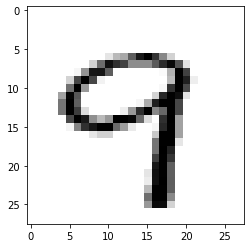

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [6]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
l1_reg = 'l1'
l2_reg = 'l2'
l1l2_reg = 'l1l2'

bn = 'batchnorm'
gbn = 'ghostbatchnorm'




In [8]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [9]:

dropout = 0.05
class Net(nn.Module):
    def __init__(self, norm_type, num_splits):
        def Norm(out_channels, norm_type, num_splits):
          if norm_type == 'gbn':
            return GhostBatchNorm(out_channels, num_splits)
          else:
            return nn.BatchNorm2d(out_channels)

        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            Norm(10, norm_type, num_splits),
            # nn.Dropout(dropout)
        ) # output_size = 26

        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            Norm(12, norm_type, num_splits),
            # nn.Dropout(dropout)
        ) 
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            Norm(12, norm_type, num_splits),
            nn.Dropout(dropout)
        ) 

        
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            Norm(16, norm_type, num_splits),
            # nn.Dropout(dropout)
        ) 

        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            Norm(16, norm_type, num_splits),
            # nn.Dropout(dropout)
        ) 
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            Norm(16, norm_type, num_splits),
            nn.Dropout(dropout)
        ) 
        
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            Norm(10, norm_type, num_splits),
            # nn.Dropout(dropout)
        ) 

        self.pool2 = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
       
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('bn', 1).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 12, 24, 24]           1,080
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
            Conv2d-7           [-1, 12, 22, 22]           1,296
              ReLU-8           [-1, 12, 22, 22]               0
       BatchNorm2d-9           [-1, 12, 22, 22]              24
          Dropout-10           [-1, 12, 22, 22]               0
        MaxPool2d-11           [-1, 12, 11, 11]               0
           Conv2d-12             [-1, 16, 9, 9]           1,728
             ReLU-13             [-1, 16, 9, 9]               0
      BatchNorm2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

# Regularisations

In [11]:
def l1_regularisation(model, l1_val):
  if l1_val <= 0:
    return 0 
  l1_criteria = nn.L1Loss(size_average=False)
  loss, regulariser_loss = 0, 0
  for parameter in model.parameters():
      regulariser_loss += l1_criteria(parameter, torch.zeros_like(parameter))
  loss += l1_val * regulariser_loss
  return loss

In [12]:

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, l1_val):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)


    # total_loss = (regular == 'l1' or regular == 'l1l2') * l1(labda) + (regular == 'l2' or regular == 'l1l2') * l2()

    # Calculate loss
    loss = F.nll_loss(y_pred, target) + l1_regularisation(model, l1_val)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, incorrect_samples):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            images = data
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            result = pred.eq(target.view_as(pred))

            # Save incorrect samples
            if len(incorrect_samples) < 25:
                for i in range(test_loader.batch_size):
                    if not list(result)[i]:
                        incorrect_samples.append({
                            'prediction': list(pred)[i],
                            'label': list(target.view_as(pred))[i],
                            'image': list(images)[i]
                        })

            correct += result.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [13]:
num_splits = 2
norm_list = ['bn', 'bn', 'bn', 'gbn', 'gbn']
regular_l1_list = [1e-3, 0, 1e-3, 0, 1e-4]
regular_l2_list = [0, 1e-4, 1e-4, 0, 1e-4]
versions = ['L1 + BN', 'L2 + BN', 'L1 + L2 + BN', 'GBN', 'L1 + L2 + GBN']

all_test_losses, all_test_acc = [], []

from torch.optim.lr_scheduler import StepLR

incorrect_samples_list = []
for i in range(5):
  print('\n' + versions[i] + '\n')
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  incorrect_samples = []
  # all_test_losses, all_test_acc = [], []
  model =  Net(norm_list[i], num_splits).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = regular_l2_list[i])
  scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
  EPOCHS = 25
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, regular_l1_list[i])
      test(model, device, test_loader, incorrect_samples)
  incorrect_samples_list.append(incorrect_samples)
  # all_train_losses.append(train_losses)
  all_test_losses.append(test_losses)
  # all_train_acc.append(train_acc)
  all_test_acc.append(test_acc)


L1 + BN



  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.38881585001945496 Batch_id=937 Accuracy=94.77: 100%|██████████| 938/938 [00:18<00:00, 52.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1145, Accuracy: 9736/10000 (97.36%)

EPOCH: 1


Loss=0.4948699474334717 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:17<00:00, 52.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0875, Accuracy: 9801/10000 (98.01%)

EPOCH: 2


Loss=0.305082768201828 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:18<00:00, 51.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9820/10000 (98.20%)

EPOCH: 3


Loss=0.3394922912120819 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:18<00:00, 51.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0653, Accuracy: 9820/10000 (98.20%)

EPOCH: 4


Loss=0.5402852892875671 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:17<00:00, 52.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0841, Accuracy: 9772/10000 (97.72%)

EPOCH: 5


Loss=0.26031479239463806 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:17<00:00, 52.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0837, Accuracy: 9759/10000 (97.59%)

EPOCH: 6


Loss=0.26992008090019226 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:18<00:00, 51.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0939, Accuracy: 9717/10000 (97.17%)

EPOCH: 7


Loss=0.23714134097099304 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:18<00:00, 51.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9765/10000 (97.65%)

EPOCH: 8


Loss=0.24744059145450592 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:17<00:00, 52.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9811/10000 (98.11%)

EPOCH: 9


Loss=0.2434058040380478 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:17<00:00, 53.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9831/10000 (98.31%)

EPOCH: 10


Loss=0.37420356273651123 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:17<00:00, 53.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1339, Accuracy: 9577/10000 (95.77%)

EPOCH: 11


Loss=0.2152458131313324 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:17<00:00, 53.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9849/10000 (98.49%)

EPOCH: 12


Loss=0.24895474314689636 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:17<00:00, 52.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0881, Accuracy: 9740/10000 (97.40%)

EPOCH: 13


Loss=0.20825527608394623 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:17<00:00, 53.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0767, Accuracy: 9774/10000 (97.74%)

EPOCH: 14


Loss=0.21723631024360657 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:17<00:00, 52.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0916, Accuracy: 9720/10000 (97.20%)

EPOCH: 15


Loss=0.2368016242980957 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:18<00:00, 50.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0918, Accuracy: 9734/10000 (97.34%)

EPOCH: 16


Loss=0.36718782782554626 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:18<00:00, 52.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9834/10000 (98.34%)

EPOCH: 17


Loss=0.2677800953388214 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:17<00:00, 53.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1115, Accuracy: 9655/10000 (96.55%)

EPOCH: 18


Loss=0.29971691966056824 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:17<00:00, 54.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0746, Accuracy: 9768/10000 (97.68%)

EPOCH: 19


Loss=0.26284724473953247 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:17<00:00, 53.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1053, Accuracy: 9665/10000 (96.65%)

EPOCH: 20


Loss=0.2887931168079376 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:17<00:00, 52.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0869, Accuracy: 9736/10000 (97.36%)

EPOCH: 21


Loss=0.24584028124809265 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:17<00:00, 53.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9778/10000 (97.78%)

EPOCH: 22


Loss=0.2342015504837036 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:17<00:00, 54.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9811/10000 (98.11%)

EPOCH: 23


Loss=0.35973024368286133 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:17<00:00, 53.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0740, Accuracy: 9779/10000 (97.79%)

EPOCH: 24


Loss=0.2651034891605377 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:17<00:00, 52.86it/s]



Test set: Average loss: 0.1124, Accuracy: 9639/10000 (96.39%)


L2 + BN



  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13599221408367157 Batch_id=937 Accuracy=95.14: 100%|██████████| 938/938 [00:14<00:00, 65.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9844/10000 (98.44%)

EPOCH: 1


Loss=0.03603840619325638 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:14<00:00, 62.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9892/10000 (98.92%)

EPOCH: 2


Loss=0.02747034840285778 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:15<00:00, 62.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.007508540991693735 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:15<00:00, 62.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.09455191344022751 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:14<00:00, 63.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.10266711562871933 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:15<00:00, 62.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.2272402048110962 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:14<00:00, 64.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.037856798619031906 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:15<00:00, 62.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.004372587893158197 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:14<00:00, 64.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.024563882499933243 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:14<00:00, 64.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.09363887459039688 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:14<00:00, 63.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.017488006502389908 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:14<00:00, 63.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.006876254454255104 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:14<00:00, 63.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.04682087153196335 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:14<00:00, 63.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.015362509526312351 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:14<00:00, 63.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.16323402523994446 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:14<00:00, 64.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.12991656363010406 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:14<00:00, 64.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.013337695971131325 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:14<00:00, 63.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.003743315115571022 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:14<00:00, 62.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.0034430469386279583 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:14<00:00, 63.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.08298130333423615 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:14<00:00, 63.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.02840612269937992 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:14<00:00, 63.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.006478719413280487 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [00:14<00:00, 65.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.1291513442993164 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [00:14<00:00, 64.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)

EPOCH: 24


Loss=0.008414266631007195 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:14<00:00, 62.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)


L1 + L2 + BN

EPOCH: 0


Loss=0.3751963675022125 Batch_id=937 Accuracy=94.84: 100%|██████████| 938/938 [00:17<00:00, 52.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1331, Accuracy: 9675/10000 (96.75%)

EPOCH: 1


Loss=0.4110129177570343 Batch_id=937 Accuracy=97.29: 100%|██████████| 938/938 [00:18<00:00, 51.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0944, Accuracy: 9757/10000 (97.57%)

EPOCH: 2


Loss=0.483940064907074 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:18<00:00, 51.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0777, Accuracy: 9801/10000 (98.01%)

EPOCH: 3


Loss=0.3669115900993347 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:18<00:00, 51.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0923, Accuracy: 9723/10000 (97.23%)

EPOCH: 4


Loss=0.4009914994239807 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:17<00:00, 52.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0800, Accuracy: 9776/10000 (97.76%)

EPOCH: 5


Loss=0.2525930106639862 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:18<00:00, 50.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9813/10000 (98.13%)

EPOCH: 6


Loss=0.2905924916267395 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:18<00:00, 51.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9832/10000 (98.32%)

EPOCH: 7


Loss=0.3786921799182892 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:18<00:00, 52.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2128, Accuracy: 9352/10000 (93.52%)

EPOCH: 8


Loss=0.2586677372455597 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:17<00:00, 53.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9771/10000 (97.71%)

EPOCH: 9


Loss=0.2627469599246979 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:18<00:00, 51.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9824/10000 (98.24%)

EPOCH: 10


Loss=0.3097613453865051 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:17<00:00, 53.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0807, Accuracy: 9772/10000 (97.72%)

EPOCH: 11


Loss=0.41044583916664124 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:18<00:00, 51.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3123, Accuracy: 9003/10000 (90.03%)

EPOCH: 12


Loss=0.23438218235969543 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:17<00:00, 53.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9815/10000 (98.15%)

EPOCH: 13


Loss=0.22137433290481567 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:18<00:00, 51.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0643, Accuracy: 9819/10000 (98.19%)

EPOCH: 14


Loss=0.2696109414100647 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:17<00:00, 52.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0861, Accuracy: 9770/10000 (97.70%)

EPOCH: 15


Loss=0.24116745591163635 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:17<00:00, 52.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9848/10000 (98.48%)

EPOCH: 16


Loss=0.29814112186431885 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:18<00:00, 51.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1064, Accuracy: 9709/10000 (97.09%)

EPOCH: 17


Loss=0.45834779739379883 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:18<00:00, 50.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1021, Accuracy: 9688/10000 (96.88%)

EPOCH: 18


Loss=0.3051703870296478 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:18<00:00, 51.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0856, Accuracy: 9749/10000 (97.49%)

EPOCH: 19


Loss=0.21217238903045654 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:17<00:00, 52.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9841/10000 (98.41%)

EPOCH: 20


Loss=0.22675848007202148 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:17<00:00, 52.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1288, Accuracy: 9580/10000 (95.80%)

EPOCH: 21


Loss=0.2097586691379547 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:18<00:00, 51.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9863/10000 (98.63%)

EPOCH: 22


Loss=0.24220162630081177 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:18<00:00, 51.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 9803/10000 (98.03%)

EPOCH: 23


Loss=0.201764315366745 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:17<00:00, 53.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1048, Accuracy: 9666/10000 (96.66%)

EPOCH: 24


Loss=0.2197495549917221 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:18<00:00, 50.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 9800/10000 (98.00%)


GBN

EPOCH: 0


Loss=0.3347044587135315 Batch_id=937 Accuracy=93.88: 100%|██████████| 938/938 [00:14<00:00, 62.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9852/10000 (98.52%)

EPOCH: 1


Loss=0.20604445040225983 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:14<00:00, 62.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9887/10000 (98.87%)

EPOCH: 2


Loss=0.07897837460041046 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:14<00:00, 65.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9911/10000 (99.11%)

EPOCH: 3


Loss=0.06067591905593872 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:14<00:00, 63.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9920/10000 (99.20%)

EPOCH: 4


Loss=0.041575394570827484 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:14<00:00, 62.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.1850886195898056 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:15<00:00, 60.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.05841889604926109 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:14<00:00, 62.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.08432041853666306 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:14<00:00, 63.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.012519161216914654 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:15<00:00, 62.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.017445236444473267 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:14<00:00, 64.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.018305635079741478 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:14<00:00, 62.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.0862976536154747 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:14<00:00, 63.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.05703769996762276 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:14<00:00, 65.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.15303464233875275 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:15<00:00, 59.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.01588072068989277 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:14<00:00, 64.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.15614378452301025 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:14<00:00, 63.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.030075889080762863 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:15<00:00, 61.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.21216869354248047 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:15<00:00, 61.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.022202637046575546 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:14<00:00, 63.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9946/10000 (99.46%)

EPOCH: 19


Loss=0.05292501300573349 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:14<00:00, 64.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.0200737863779068 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:14<00:00, 63.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.10577992349863052 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:14<00:00, 65.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9947/10000 (99.47%)

EPOCH: 22


Loss=0.017584778368473053 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:14<00:00, 64.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.020260922610759735 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:14<00:00, 62.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.02587592974305153 Batch_id=937 Accuracy=99.48: 100%|██████████| 938/938 [00:14<00:00, 63.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99.45%)


L1 + L2 + GBN

EPOCH: 0


Loss=0.2583285868167877 Batch_id=937 Accuracy=94.48: 100%|██████████| 938/938 [00:19<00:00, 48.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9854/10000 (98.54%)

EPOCH: 1


Loss=0.23118025064468384 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:19<00:00, 48.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.14660553634166718 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:18<00:00, 50.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9919/10000 (99.19%)

EPOCH: 3


Loss=0.14422425627708435 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:18<00:00, 50.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.12777818739414215 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:18<00:00, 49.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.3010173439979553 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:18<00:00, 49.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.15282359719276428 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:18<00:00, 49.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.23106715083122253 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:18<00:00, 49.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.20803365111351013 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:18<00:00, 51.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.07377009093761444 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:18<00:00, 50.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.37957465648651123 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:18<00:00, 50.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9885/10000 (98.85%)

EPOCH: 11


Loss=0.06684328615665436 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:18<00:00, 50.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.09276562184095383 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:18<00:00, 50.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.09489205479621887 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:18<00:00, 49.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9885/10000 (98.85%)

EPOCH: 14


Loss=0.07578398287296295 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:18<00:00, 50.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9900/10000 (99.00%)

EPOCH: 15


Loss=0.085207998752594 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:18<00:00, 50.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9906/10000 (99.06%)

EPOCH: 16


Loss=0.09067918360233307 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:18<00:00, 50.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9890/10000 (98.90%)

EPOCH: 17


Loss=0.09892945736646652 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:18<00:00, 49.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9912/10000 (99.12%)

EPOCH: 18


Loss=0.07418933510780334 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:18<00:00, 50.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99.19%)

EPOCH: 19


Loss=0.09026946127414703 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:18<00:00, 50.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.255893349647522 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:18<00:00, 51.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.09815378487110138 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:18<00:00, 51.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9916/10000 (99.16%)

EPOCH: 22


Loss=0.07843618839979172 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:18<00:00, 50.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9918/10000 (99.18%)

EPOCH: 23


Loss=0.053877878934144974 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:18<00:00, 50.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9903/10000 (99.03%)

EPOCH: 24


Loss=0.06920911371707916 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:18<00:00, 51.51it/s]



Test set: Average loss: 0.0321, Accuracy: 9896/10000 (98.96%)



In [14]:

def plot_metric(l1, l2, l1_l2, gbn, l1_l2_gbn, metric):
    # Initialize a figure
    fig = plt.figure(figsize=(13, 11))

    # Plot values
    l1_plt, = plt.plot(l1)
    l2_plt, = plt.plot(l2)
    l1_l2_plt, = plt.plot(l1_l2)
    gbn_plt, = plt.plot(gbn)
    l1_l2_gbn_plt, = plt.plot(l1_l2_gbn)

    # Set plot title
    plt.title(f'Validation {metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if metric == 'Loss' else 'lower'
    plt.legend(
        (l1_plt, l2_plt, l1_l2_plt, gbn_plt, l1_l2_gbn_plt),
        ('L1 + BN', 'L2 + BN', 'L1 + L2 + BN', 'GBN', 'L1 + L2 + GBN'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 20}
    )

    # Save plot
    fig.savefig(f'{metric.lower()}_change.png')
    


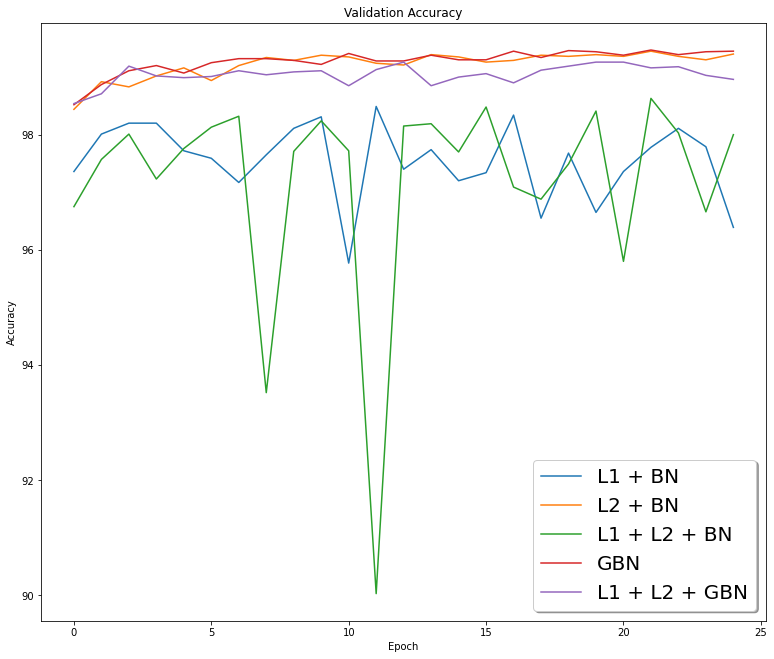

In [15]:
# Plotting test accuracy
plot_metric(all_test_acc[0], all_test_acc[1], all_test_acc[2], all_test_acc[3], all_test_acc[4], 'Accuracy')

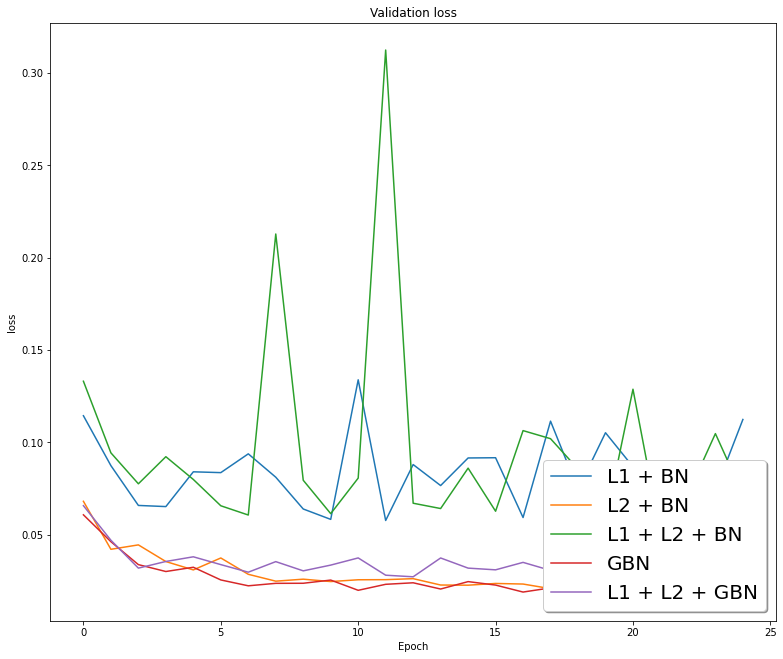

In [16]:
# Plotting loss accuracy
plot_metric(*all_test_losses, 'loss')

In [17]:
def print_images(data, metric):
    # Initialize plot
    row_count = -1
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    fig.tight_layout()

    for idx, result in enumerate(data):

        # If 25 samples have been stored, break out of loop
        if idx > 24:
            break
        
        label = result['label'].item()
        prediction = result['prediction'].item()

        # Plot image
        if idx % 5 == 0:
            row_count += 1
        axs[row_count][idx % 5].axis('off')
        axs[row_count][idx % 5].set_title(f'Label: {label}\nPrediction: {prediction}')
        axs[row_count][idx % 5].imshow(result['image'][0], cmap='gray_r')

        # Save each image individually in labelled format
        extent = axs[row_count][idx % 5].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        # fig.savefig(f'{metric}/labelled/{metric}_{idx + 1}.png', bbox_inches=extent.expanded(1.1, 1.5))
    
    # Save image
    # fig.savefig(f'{metric}/{metric}_incorrect_predictions.png', bbox_inches='tight')

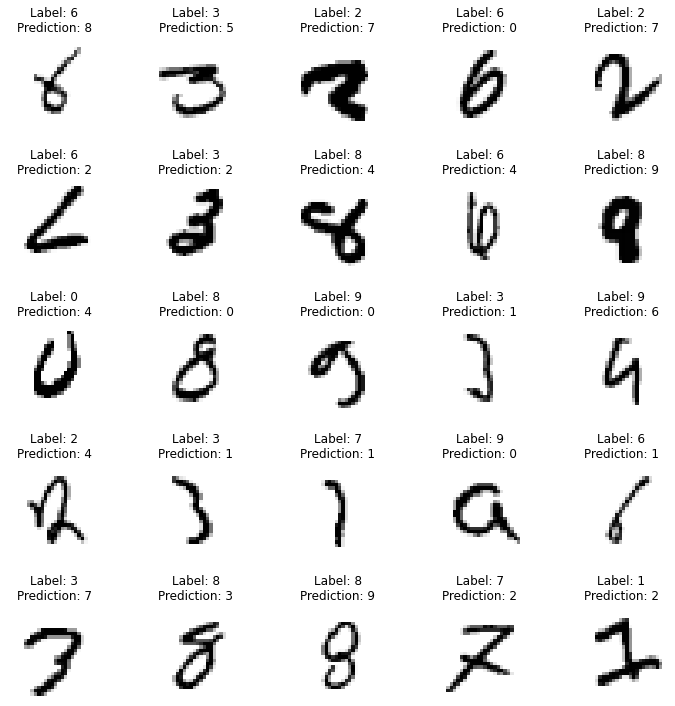

In [18]:
print_images(incorrect_samples_list[3], 'GBN')